# Projet Machine Learning sur la base DVF

## Oumakhlouf Selym
## Marchand Florian

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# 1. Introduction


Prédire au mieux le prix d’un appartement à partir de
ses autres caractéristiques.

On va utiliser la base de données DVF.

# 2. Analyse des Données

In [5]:
dvf = pd.read_csv('./DVF_train.csv', dtype={'code_departement':'str', 'code_postal': 'str'})

In [6]:
dvf

,Unnamed: 0,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,3612399,2023-08-03,165410.0,94160.0,94,Appartement,17.0,1.0,NaN,2.416612,48.840466
1,2979296,2023-05-23,170900.0,78300.0,78,Appartement,80.0,4.0,NaN,2.040845,48.926907
2,545016,2023-05-31,16000.0,16000.0,16,Appartement,20.0,1.0,NaN,0.170911,45.651279
3,2497199,2023-06-29,240000.0,65400.0,65,Appartement,75.0,3.0,621.0,-0.068876,42.988343
4,3207821,2023-02-16,522000.0,84400.0,84,Maison,165.0,5.0,1000.0,5.384564,43.911069
...,...,...,...,...,...,...,...,...,...,...,...
703768,1045273,2023-01-03,60000.0,30000.0,30,Appartement,22.0,1.0,NaN,4.396774,43.854210
703769,1837384,2023-04-07,250000.0,46230.0,46,Maison,140.0,4.0,500.0,1.546814,44.344308
703770,579086,2023-05-24,558000.0,17139.0,17,Maison,135.0,6.0,657.0,-1.056342,46.192404
703771,1722782,2023-04-11,360000.0,44230.0,44,Maison,74.0,4.0,363.0,-1.489895,47.198482


In [30]:
print(f"La base de données DVF est une base de données contenant {dvf.shape[0]} lignes contenant chacune {dvf.shape[1]} elements.")

La base de données DVF est une base de données contenant 703773 lignes contenant chacune 11 elements.


On remarque que les departements d'outre-mer ne sont pas present et que les deux departements de corses sont reunit sur le 20eme departement.

In [52]:
max_transac = dvf['valeur_fonciere'].describe().apply(lambda x: format(x,'f'))['max']
min_transac = dvf['valeur_fonciere'].describe().apply(lambda x: format(x,'f'))['min']

In [6]:
print(f"La transaction la plus elevée sur cette base est de {float(max_transac)}€")
print(f"La transaction la plus faible sur cette base est de {float(min_transac)}€")

La transaction la plus elevée sur cette base est de 9900000.0€
La transaction la plus faible sur cette base est de 10000.0€


L'etendue etant beaucoup trop elevé (de 10_000 a 9_900_000), utiliser la mediane pourrai etre plus reprensentatif de la realité par moment.

In [12]:
avg_dep = [dvf['valeur_fonciere'].loc[dvf['code_departement'] == str(i)].mean() for i in range(1,96)]
size_dep = [dvf.loc[dvf['code_departement'] == str(i)].shape[0] for i in range(1,96)]


In [13]:
avg_dep_sorted = sorted(avg_dep)
avg_dep_sorted.reverse()

In [14]:
for i in range(10):
    print(f"Le departement du {avg_dep.index(avg_dep_sorted[i]) + 1} est le {i+1}{'er' if i == 0 else 'ème'} dont les transactions sont les plus couteuses avec en moyenne {round(avg_dep_sorted[i],2)}€")

Le departement du 92 est le 1er dont les transactions sont les plus couteuses avec en moyenne 996875.16€
Le departement du 75 est le 2ème dont les transactions sont les plus couteuses avec en moyenne 945219.32€
Le departement du 94 est le 3ème dont les transactions sont les plus couteuses avec en moyenne 842270.65€
Le departement du 6 est le 4ème dont les transactions sont les plus couteuses avec en moyenne 593832.99€
Le departement du 69 est le 5ème dont les transactions sont les plus couteuses avec en moyenne 570812.74€
Le departement du 78 est le 6ème dont les transactions sont les plus couteuses avec en moyenne 558901.65€
Le departement du 83 est le 7ème dont les transactions sont les plus couteuses avec en moyenne 556157.36€
Le departement du 73 est le 8ème dont les transactions sont les plus couteuses avec en moyenne 550525.49€
Le departement du 74 est le 9ème dont les transactions sont les plus couteuses avec en moyenne 545276.43€
Le departement du 95 est le 10ème dont les trans

In [15]:
def posByCost(dep):
    '''
    Cette fonction permet de determiner quelle est la position 
    d'un departement par rapport au cout moyen des transactions.
    renvoie la position, prix moyen, nombre de transactions
    '''
    avg = avg_dep[dep-1]
    return avg_dep_sorted.index(avg) +1, round(avg, 2), size_dep[dep-1]

In [16]:
posByCost(77)

(27, np.float64(358483.02), 13986)

In [17]:
dvf['type_local_encoded'], _ = pd.factorize(dvf['type_local'])  #  permet d'ajouter le type_local dans la matrice de correlation 

In [18]:
dvf_corr = dvf[['valeur_fonciere','code_postal', 'surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'type_local_encoded', 'longitude', 'latitude']].dropna().corr(numeric_only=True)  # supprime les valeur manquant et calcule la matrice de correlation

dvf_corr


,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,type_local_encoded,longitude,latitude
valeur_fonciere,1.000000,0.053334,-0.005101,0.125885,-0.272653,0.088359,-0.035193
surface_reelle_bati,0.053334,1.000000,0.762907,0.055395,0.346472,-0.017826,-0.036606
nombre_pieces_principales,-0.005101,0.762907,1.000000,0.019770,0.378748,-0.036096,0.045846
surface_terrain,0.125885,0.055395,0.019770,1.000000,-0.025177,-0.001257,-0.018876
type_local_encoded,-0.272653,0.346472,0.378748,-0.025177,1.000000,-0.135025,0.036722
longitude,0.088359,-0.017826,-0.036096,-0.001257,-0.135025,1.000000,-0.196716
latitude,-0.035193,-0.036606,0.045846,-0.018876,0.036722,-0.196716,1.000000


Sur cette matrice de correlation (on cherche les données les plus correlés aux valeurs foncieres), la donnée qui semble etre le plus correlé au prix est le type d'habitation (bien que ca reste une faible correlation a -0.27). Les autres données ont une correlation bien trop faible qu'elles en deviennent negligeable.

In [19]:
dvf_corr = dvf[['valeur_fonciere','code_postal', 'surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'type_local_encoded', 'longitude', 'latitude']].dropna().corr(numeric_only=True, method='spearman')  # supprime les valeur manquant et calcule la matrice de correlation


dvf_corr

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,type_local_encoded,longitude,latitude
valeur_fonciere,1.000000,0.278397,0.222784,0.237819,-0.168407,0.076845,-0.103693
surface_reelle_bati,0.278397,1.000000,0.791092,0.303503,0.415089,-0.036391,-0.032916
nombre_pieces_principales,0.222784,0.791092,1.000000,0.223554,0.398806,-0.038457,0.052064
surface_terrain,0.237819,0.303503,0.223554,1.000000,0.110379,-0.050965,-0.063921
type_local_encoded,-0.168407,0.415089,0.398806,0.110379,1.000000,-0.136729,0.033559
longitude,0.076845,-0.036391,-0.038457,-0.050965,-0.136729,1.000000,-0.155518
latitude,-0.103693,-0.032916,0.052064,-0.063921,0.033559,-0.155518,1.000000


En changeant le modele de correlation, la surface reelle bati, le nombre de pieces principales et la surface du terrain prennent un peu d'importance mais reste des correlation faible (et logique, un appartement plus grand avec plus de pieces est naturellement plus couteux si les autres données sont similaire).


Pour resumer la valeur fonciere n'est pas lié a une donné en particulier mais plus ou moins a l'ensemble des données representant un bien. Par exemple la longitude et la latitude seul n'ont aucun impact sur le prix mais reunis (coordonnées donc departement), ont obtient un liens un plus plus solide et ainsi de suite plus ont ajoute de precision sur le bien.

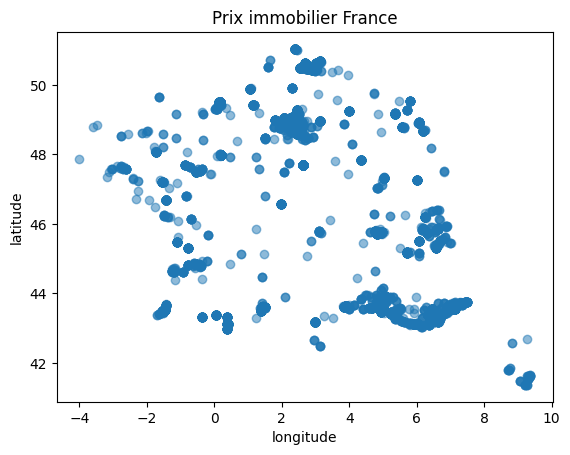

In [41]:
fig, ax = plt.subplots()
dataframe = dvf.loc[dvf['valeur_fonciere'] >= 3_000_000]
z = ax.scatter(data = dataframe, 
               x='longitude', y='latitude', 
               alpha=0.5)

ax.set(title='Prix immobilier France', xlabel='longitude', ylabel='latitude')
plt.show()

On peut observer que la plupart des logements a plus de 3_000_000 € sont situés en Ile de france et sur les litoraux (surtout Sud-Est).

In [20]:
dvf['prix_m2'] = dvf['valeur_fonciere'] / dvf['surface_reelle_bati']

In [21]:
first_dep = avg_dep.index(avg_dep_sorted[0])+1

In [22]:
transact = dvf['prix_m2'].loc[dvf['code_departement'] == str(first_dep)]
print(transact.mean())
print(transact.median())

25008.899923838373
7843.137254901961


In [45]:
print(f"Dans le {avg_dep.index(avg_dep_sorted[0]) + 1} (departement avec le prix moyen de l'immobilier le plus chere en moyenne), le prix moyen par m² est de {round(transact.mean(), 2)}€/m², la mediane est a {round(transact.median(), 2)}€")

Dans le 92 (departement avec le prix moyen de l'immobilier le plus chere en moyenne), le prix moyen par m² est de 25008.9€/m², la mediane est a 7843.14€


In [46]:
transact = dvf['prix_m2'].loc[dvf['code_departement'] == '75']
print(transact.mean())
print(transact.median())

26328.041359281884
10750.0


In [47]:
print(f"Dans le 75, le prix moyen par m² est de {round(transact.mean(), 2)}€/m², la mediane est a {round(transact.median(), 2)}€")

Dans le 75, le prix moyen par m² est de 26328.04€/m², la mediane est a 10750.0€


In [48]:
terrain_first = dvf[(dvf['surface_terrain'].notna()) & (dvf['code_departement'] == str(first_dep))]['prix_m2'].describe()
print(f"Prix moyen m² logement avec terrain dans les Hauts de Seine (92) : {int(terrain_first['mean'])}€")

not_terrain_first = dvf[(dvf['surface_terrain'].isna()) & (dvf['code_departement'] == str(first_dep))]['prix_m2'].describe()
print(f"Prix moyen m² logement sans terrain dans les Hauts de Seine (92) : {int(not_terrain_first['mean'])}€")

print(f"Surcoût moyen pour un terrain dans les Hauts de Seine (92) : {int(terrain_first['mean']) - int(not_terrain_first['mean'])}€")
print()

terrain_Paris = dvf[(dvf['surface_terrain'].notna()) & (dvf['code_departement'] == '75')]['prix_m2'].describe()
print(f"Prix moyen m² logement avec terrain dans Paris (75) : {int(terrain_Paris['mean'])}€")

not_terrain_Paris = dvf[(dvf['surface_terrain'].isna()) & (dvf['code_departement'] == '75')]['prix_m2'].describe()
print(f"Prix moyen m² logement sans terrain dans Paris (75): {int(not_terrain_Paris['mean'])}€")

print(f"Surcoût moyen pour un terrain dans Paris (75) : {int(terrain_Paris['mean']) - int(not_terrain_Paris['mean'])}€")

Prix moyen m² logement avec terrain dans les Hauts de Seine (92) : 36749€
Prix moyen m² logement sans terrain dans les Hauts de Seine (92) : 19524€
Surcoût moyen pour un terrain dans les Hauts de Seine (92) : 17225€

Prix moyen m² logement avec terrain dans Paris (75) : 137491€
Prix moyen m² logement sans terrain dans Paris (75): 14163€
Surcoût moyen pour un terrain dans Paris (75) : 123328€


# 3. Méthodologie

In [37]:
dvf['date_mutation'] = pd.to_datetime(dvf['date_mutation'])
dvf['date_numeric'] = (dvf['date_mutation'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')  # converti les date en format numerique

In [38]:
dvf.fillna(0, inplace=True)  # remplace les nan par des 0 
X = dvf.drop(columns=['valeur_fonciere', 'date_mutation', 'type_local'])  # Recupere les données de la base sans les labels et valeur non numerique
y = dvf['valeur_fonciere']

## LinearRegression :

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [57]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [58]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
mse

235317056299.68204

Une MSE de 194 milliards est vraiment catastrophique, le modele est totalement hors sujet avec cette base de donnée.

In [28]:
def accuracy(y_pred, y_test, tolerance = 1000):
    return np.mean((y_pred <= y_test + tolerance) & (y_pred >= y_test - tolerance))*100

In [29]:
def test_model(model, loop = 5, test = True, tolerance = 1000):
    sum = 0
    for i in range(loop):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        m =model.fit(X_train, y_train)
        if test : 
            y_pred = m.predict(X_test)
            sum += accuracy(y_pred, y_test, tolerance)
        else :
            y_pred = m.predict(X_train)
            sum += accuracy(y_pred, y_train, tolerance)
        
    return round(sum /loop, 2)

In [61]:
test_model(LinearRegression())

np.float64(0.63)

Avec une tolerance a 1000€ pres, le model a une prediction de 0.57%, ce qui est catastrophique et rejoind l'idee de la mse. 

## RandomForestRegressor :

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train) 

RandomForestRegressor(n_estimators=10)

In [64]:
y_pred = model.predict(X_test)
print(f"Avec 1000€ de tolerance, accu : {round(accuracy(y_pred, y_test), 2)}%")  # avec tolerance de 1000€ par default

Avec 1000€ de tolerance, accu : 90.04%


In [65]:
print(f"Avec 100€ de tolerance, accu : {round(accuracy(y_pred, y_test, tolerance=100), 2)}%")

Avec 100€ de tolerance, accu : 57.68%


Le model RamdomForestRegressor est bien meilleur que le linearRegressor passant de 0.6% a 90% d'accuracy avec 1000€ de tolerance.

En baissant la tolerance a 100€ le modele passe a 57% d'accuracy ne qui n'est pas vraiment bon.

In [81]:
for i in range (1, 10, 1) : 
    model = RandomForestRegressor(n_estimators = i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"i = {i}")
    print(f"Avec 1000€ de tolerance, accu : {round(accuracy(y_pred, y_test), 2)}%")  # avec tolerance de 1000€ par default
    print(f"Avec 100€ de tolerance, accu : {round(accuracy(y_pred, y_test, tolerance=100), 2)}%")
    print()

i = 1
Avec 1000€ de tolerance, accu : 85.59%
Avec 100€ de tolerance, accu : 63.29%

i = 2
Avec 1000€ de tolerance, accu : 86.44%
Avec 100€ de tolerance, accu : 58.86%

i = 3
Avec 1000€ de tolerance, accu : 87.19%
Avec 100€ de tolerance, accu : 56.56%

i = 4
Avec 1000€ de tolerance, accu : 87.82%
Avec 100€ de tolerance, accu : 55.64%

i = 5
Avec 1000€ de tolerance, accu : 88.44%
Avec 100€ de tolerance, accu : 56.25%

i = 6
Avec 1000€ de tolerance, accu : 88.93%
Avec 100€ de tolerance, accu : 56.02%

i = 7
Avec 1000€ de tolerance, accu : 89.12%
Avec 100€ de tolerance, accu : 56.03%

i = 8
Avec 1000€ de tolerance, accu : 89.45%
Avec 100€ de tolerance, accu : 55.89%

i = 9
Avec 1000€ de tolerance, accu : 89.78%
Avec 100€ de tolerance, accu : 55.89%



Le gain de précision stagne

## GradientBoostingRegressor :

In [83]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [84]:
print(f"Avec 100€ de tolerance, accu : {round(accuracy(y_pred, y_test, tolerance=100), 2)}%")

Avec 100€ de tolerance, accu : 0.12%


In [85]:
print(f"Avec 1000€ de tolerance, accu : {round(accuracy(y_pred, y_test), 2)}%")  # avec tolerance de 1000€ par default

Avec 1000€ de tolerance, accu : 0.8%


## DecisionTreeRegressor :

In [76]:
from sklearn.tree import DecisionTreeRegressor

for i in range (10, 150, 10) : 
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"i = {i}")
    print(f"Avec 1000€ de tolerance, accu : {round(accuracy(y_pred, y_test), 2)}%")  # avec tolerance de 1000€ par default
    print(f"Avec 100€ de tolerance, accu : {round(accuracy(y_pred, y_test, tolerance=100), 2)}%")
    print()

i = 10
Avec 1000€ de tolerance, accu : 5.48%
Avec 100€ de tolerance, accu : 0.67%

i = 20
Avec 1000€ de tolerance, accu : 89.43%
Avec 100€ de tolerance, accu : 64.39%

i = 30
Avec 1000€ de tolerance, accu : 90.23%
Avec 100€ de tolerance, accu : 71.66%

i = 40
Avec 1000€ de tolerance, accu : 90.21%
Avec 100€ de tolerance, accu : 71.71%

i = 50
Avec 1000€ de tolerance, accu : 90.16%
Avec 100€ de tolerance, accu : 71.65%

i = 60
Avec 1000€ de tolerance, accu : 90.23%
Avec 100€ de tolerance, accu : 71.66%

i = 70
Avec 1000€ de tolerance, accu : 90.2%
Avec 100€ de tolerance, accu : 71.65%

i = 80
Avec 1000€ de tolerance, accu : 90.21%
Avec 100€ de tolerance, accu : 71.69%

i = 90
Avec 1000€ de tolerance, accu : 90.18%
Avec 100€ de tolerance, accu : 71.65%

i = 100
Avec 1000€ de tolerance, accu : 90.13%
Avec 100€ de tolerance, accu : 71.57%

i = 110
Avec 1000€ de tolerance, accu : 90.23%
Avec 100€ de tolerance, accu : 71.71%

i = 120
Avec 1000€ de tolerance, accu : 90.26%
Avec 100€ de tolera

On comprend qu'il n'est pas nécessaire d'utiliser une max_depth supérieur à 30

In [77]:
model = DecisionTreeRegressor(max_depth=30)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [78]:
print(f"Avec 1000€ de tolerance, accu : {round(accuracy(y_pred, y_test), 2)}%")  # avec tolerance de 1000€ par default

Avec 1000€ de tolerance, accu : 90.26%


In [79]:
print(f"Avec 100€ de tolerance, accu : {round(accuracy(y_pred, y_test, tolerance=100), 2)}%")

Avec 100€ de tolerance, accu : 71.69%


## Réseau de Neurones :

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
number_col = ['valeur_fonciere', 'surface_reelle_bati', 'surface_terrain', 'prix_m2']
dvf[number_col].fillna(dvf[number_col].median())

categorie_col = ['code_postal', 'code_departement', 'type_local_encoded']
dvf[categorie_col].fillna('-1')

X = dvf.drop(columns=['valeur_fonciere', 'date_mutation', 'type_local', 'prix_m2']) # Recupere les données de la base sans les labels et valeur non numerique
y = dvf['valeur_fonciere']
X_train, X_test, y_train, y_test = train_test_split(X, y)


y_train = y_train[y_train < 1_000_000]  # Exclure les valeurs trop extrêmes
X_train = X_train.loc[y_train.index]

print(X_train.select_dtypes(include=['object']).columns)  # ces colonnes ne sont pas des nombres, il faut les convertir

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X.shape

Index(['code_postal', 'code_departement'], dtype='object')


(703773, 10)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='relu')
])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['mse']
)

In [ ]:
model.summary()

Dans un premier temps, utiliser un reseau de neurone avec 3 layers et 3000 parametres. 

In [ ]:
model.fit(X_train, y_train, epochs=100)

In [ ]:
model.evaluate(X_train, y_train, verbose = 2)

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten().astype(int)
y_pred

In [ ]:
accuracy(y_pred, y_test, tolerance = 1000)

Le modele a actuelement une mse > 1 milliard, c'est vraiment mauvais (lié au format des données plus qu'au model).

# 4. Expérimentations et Résultats

Dans un premier temps, le modele LinearRegression a été un modele catastrophique pour cette base de donnée. En effet, le modele est bien trop simpliste pour une base aussi grande et contenant des données de dimension 10. 

Le second modele est bien plus performant donnant des estimations des biens avec un bon ordre de grandeur (~1000€ pres).

Cepandant si l'on veut un modele avec un peu plus de precision (~100€ pres), il ne devient plus assez efficace.

Pour finir utiliser un reseau de neurone est une solution bien souvent plus performant mais necessite bien plus de ressource et temps d'entrainement.

# 5. Conclusion et Perspectives


Le `RandomForestRegressor` offre un bon compromis entre précision et rapidité, bien qu'il puisse être relativement lent, surtout pour des datasets volumineux. Cependant, atteindre une précision de l'ordre de 100€ nécessite des optimisations supplémentaires ou des modèles plus avancés.

D'autre part, le `DecisionTreeRegressor` se distingue par sa rapidité d'exécution et sa performance, parfois même supérieure à celle du RandomForestRegressor, surtout lorsque des ajustements sont faits au niveau de la profondeur de l'arbre.